### Santiago García - Catalina Guatibonza

# PARCIAL 2 | MÉTODOS COMPUTACIONALES II

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Algoritmo Multipaso

In [2]:
def f(x, y):
    return x + 2*y

def RungeKutta4(x, y, h):
    for i in range(1, len(x)):
        k1 = f(x[i-1], y[i-1])
        k2 = f(x[i-1] + 0.5*h, y[i-1] + 0.5*k1*h)
        k3 = f(x[i-1] + 0.5*h, y[i-1] + 0.5*k2*h)
        k4 = f(x[i-1] + h, y[i-1] + k3*h)
        
        y[i] = y[i-1] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return y

In [3]:
def Bashford(x, y, h):
    for i in range(3, len(x) - 1):
        y[i+1] = y[i] + h*((1901/720)*f(x[i], y[i]) - 
                           (2774/720)*f(x[i-1], y[i-1]) + 
                           (2616/720)*f(x[i-2], y[i-2]) - 
                           (1274/720)*f(x[i-3], y[i-3]) + 
                           (251/720)*f(x[i-4], y[i-4]))
    return y

In [4]:
def Moulton(x, y, h):
    for i in range(3, len(x) - 1):
        y_temp = y[i] + h*((475/1440)*f(x[i+1], y[i+1]) + 
                           (1427/1440)*f(x[i], y[i]) - 
                           (798/1440)*f(x[i-1], y[i-1]) + 
                           (482/1440)*f(x[i-2], y[i-2]) - 
                           (173/1440)*f(x[i-3], y[i-3]) + 
                           (27/1440)*f(x[i-4], y[i-4]))
        
        y[i+1] = y_temp
    return y

In [5]:
def Exacta(x):
    return -0.5*x - (1 - np.exp(2*x)) / 4

In [6]:
x = np.linspace(0, 4, 100)
h = x[1] - x[0]
y = np.zeros_like(x)
y[0] = 0 

In [7]:
y_rk4 = RungeKutta4(x, y, h)
y_predicted = Bashford(x, y_rk4, h)
y_corrected = Moulton(x, y_predicted, h)
y_exact = Exacta(x)

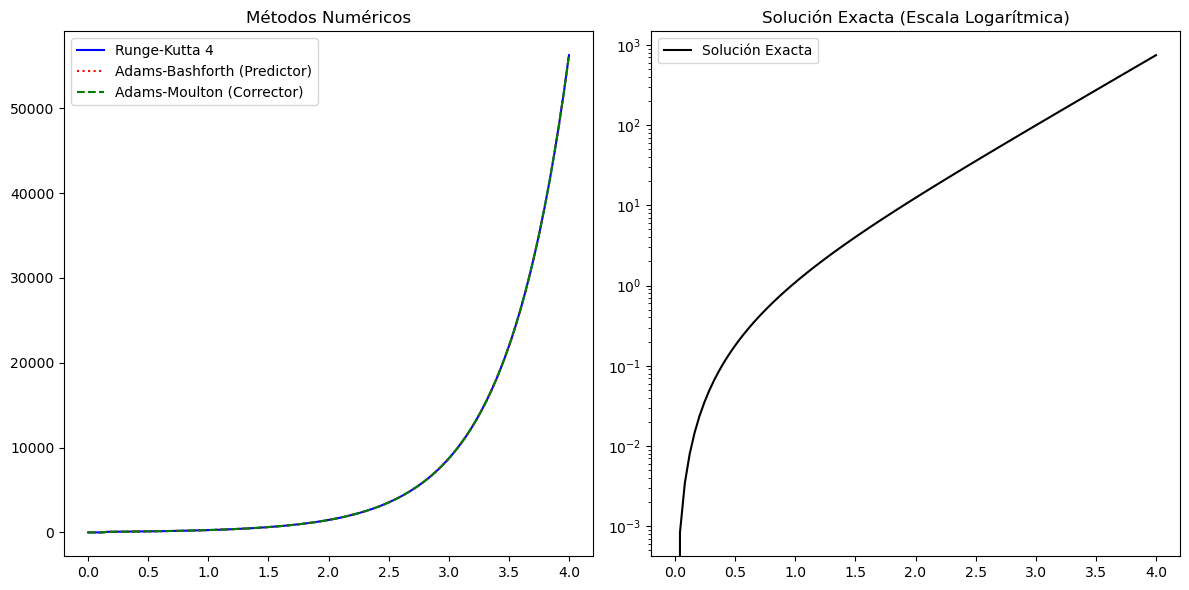

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y_rk4, label='Runge-Kutta 4', color='blue')
plt.plot(x, y_predicted, label='Adams-Bashforth (Predictor)', color='red', linestyle=':')
plt.plot(x, y_corrected, label='Adams-Moulton (Corrector)', color='green', linestyle='--')
plt.legend()
plt.title('Runge Kutta, Bashford & Moulton')

plt.subplot(1, 2, 2)
plt.plot(x, y_exact, label='Solución Exacta', color='black', linestyle='-')
plt.yscale('log')
plt.legend()
plt.title('Solución Exacta (Escala Logarítmica)')

plt.tight_layout()
plt.show()

## Particle Decay (Adaptativo) 